In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# source : https://www.analyticsvidhya.com/blog/2021/05/anomaly-detection-using-autoencoders-a-walk-through-in-python/ 
# https://colab.research.google.com/drive/1TXaQzsSj2q0E3Ni1uxFDXGpY1SCnu46v?usp=sharing#scrollTo=OTEDLRtA4I9k 

## Load the data

In [52]:
# Download the dataset
# PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

# data = pd.read_csv(PATH_TO_DATA, header=None)
# print(data.shape)
# data.head()

# import data set from the local driver 
df=pd.read_csv('SWaT_Dataset_Attack_v0 - Copy.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
df.head(2)     

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal


In [53]:
# drop the Acutotor colomuns 
#df1=df.drop(['Timestamp',' MV101','P101','P102', ' MV201', ' P201', ' P202','P203', ' P204','P205','P206','MV301','MV302',' MV303','MV304','P301','P302','P401','P402','P403','P404','UV401','P501','P502','P601','P602','P603'],axis=1)#, inplace=True)
# drop the Acutotor colomuns 
df1=df.drop(['Timestamp',' MV101','P101','P102', ' MV201', ' P201', ' P202','P203', ' P204','P205','P206','MV301','MV302',' MV303','MV304','P301','P302','P401','P402','P403','P404','UV401','P501','P502','P601','P602','P603'],axis=1)#, inplace=True)   

In [54]:
# Rename the col name Normal/Attack with A  
df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)
df1.head(2)   

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,2.427057,522.8467,262.0161,8.396437,328.6337,2.445391,19.74838,2.206835,956.1651,148.808,...,12.03538,1.723789,1.279621,0.735269,0.307786,250.8652,1.649953,189.5988,0.000128,Normal
1,2.446274,522.8860,262.0161,8.396437,328.6337,2.445391,19.74838,2.208244,956.1651,148.808,...,12.03538,1.723789,1.297554,0.735269,0.307786,250.8652,1.649953,189.6789,0.000128,Normal


In [55]:
df1['Normal/Attack'] = df1['A'].str.replace(' ', '')  

size of class 1 (outliers): 0, size of class 0: 0


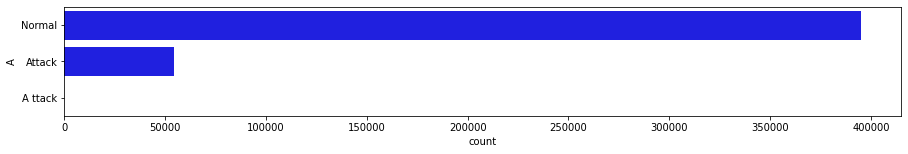

In [56]:
import seaborn as sns #visualisation
# Plot the balance of class labels
df_base = df1.copy()
nominal_count = len(df_base.loc[df1['A'] == 0, 'A'])
outlier_count = len(df_base.loc[df1['A'] == 1, 'A'])
print(f'size of class 1 (outliers): {outlier_count}, size of class 0: {nominal_count}')

plt.figure(figsize=(15,2))
fig = sns.countplot(y="A", data=df_base, color='b') 

In [57]:
# Convert non-numeric to numeric

df1.A[df1.A == 'Normal'] = 0 
df1.A[df1.A == 'Attack'] = 1  

/tmp/ipykernel_120/2039620818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A == 'Normal'] = 0
/tmp/ipykernel_120/2039620818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A == 'Attack'] = 1


In [58]:
df1=df1.drop(['Normal/Attack'],axis=1)

## Split the data for training and testing

In [59]:
# last column is the target
# 0 = anomaly, 1 = normal
#TARGET = df1['A'] 

#features = df1.drop(TARGET, axis=1)
features=df1.drop(['A'],axis=1)
target = df1['A']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=1234)#, stratify=target) 

In [60]:
y_train

69476     0
80519     0
373441    0
429139    0
254580    1
         ..
294543    0
344728    0
220532    0
384053    0
165158    0
Name: A, Length: 359935, dtype: object

In [61]:
# df_normal = df1[Normal_mask]
# df_attack = df1[Attack_mask] 
# print(f"Normal count: {len(df_normal)}")
# print(f"Attack count: {len(df_attack)}")   

In [62]:
# # # This is the feature vector that goes to the neural net
# x_good = df_normal.values 
# x_bad = df_attack.values   

In [64]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

## Scale the data using MinMaxScaler

In [65]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

## Build an AutoEncoder model

In [115]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(40, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(44, activation='relu'),
      Dropout(0.1),
      Dense(36, activation='relu'),
      Dropout(0.1),
      Dense(36, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [118]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/100
86/86 [==============================] - 3s 24ms/step - loss: 0.0505 - mse: 0.1025 - val_loss: 0.0271 - val_mse: 0.0657
Epoch 2/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0137 - mse: 0.0300 - val_loss: 0.0146 - val_mse: 0.0318
Epoch 3/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0107 - mse: 0.0231 - val_loss: 0.0113 - val_mse: 0.0239
Epoch 4/100
86/86 [==============================] - 2s 22ms/step - loss: 0.0086 - mse: 0.0187 - val_loss: 0.0104 - val_mse: 0.0217
Epoch 5/100
86/86 [==============================] - 2s 22ms/step - loss: 0.0076 - mse: 0.0166 - val_loss: 0.0100 - val_mse: 0.0210
Epoch 6/100
86/86 [==============================] - 2s 22ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0097 - val_mse: 0.0203
Epoch 7/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0093 - val_mse: 0.0196
Epoch 8/100
86/86 [==============================] - 2s 24ms/step - loss: 0.

## Plot history

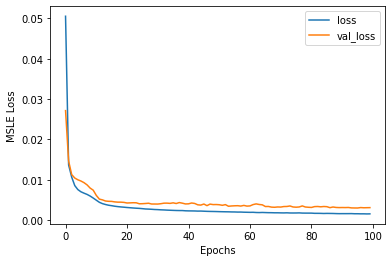

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Find threshold

In [120]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [121]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

Threshold method one: 0.0038831048139879353
Threshold method two: 0.0037323796718189218


#### Measure the Perfomance of the Model 

In [132]:
# # to check what metrics we provide 
# model.metrics_names
# score=model.evaluate(x_test_scaled,x_test_scaled)#,batch_size=128)

In [126]:
preds = get_predictions(model, x_test_scaled, threshold)
#preds
y_test
#accuracy_score(preds, y_test)
#accuracy_score(y_test, np.round(abs(preds)), normalize=False)   

292561    0
305362    0
61682     0
439720    0
45559     0
         ..
158913    0
355828    0
345600    0
108649    0
190615    0
Name: A, Length: 89984, dtype: object

In [123]:
from sklearn.metrics import (confusion_matrix,precision_recall_curve)  
# get (mis)classification
# cm = confusion_matrix(y_test, preds) 
# cm

In [91]:
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
# print('Recall: %.3f' % recall_score(y_test, preds)) 
# print('Precision: %.3f' % precision_score(y_test, preds)) 

 

#### Detecting anomalies 
- https://keras.io/examples/timeseries/timeseries_anomaly_detection/ 

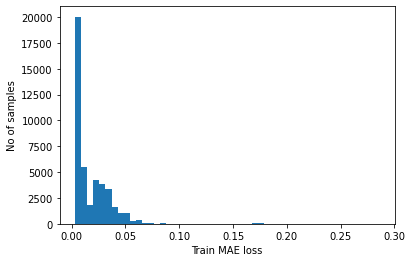

Reconstruction error threshold:  0.28604644631764303


In [133]:
# Get train MAE loss.
x_train_pred = model.predict(x_train_scaled)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_scaled), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold) 

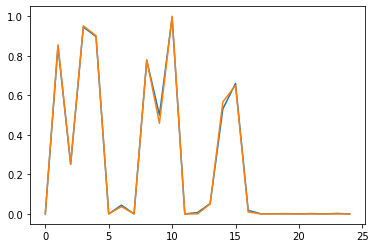

In [134]:
# Checking how the first sequence is learnt
plt.plot(x_train_scaled[0])
plt.plot(x_train_pred[0])
plt.show() 

## Tuning AutoEncoder using keras tuner



In [107]:
#!pip install -U keras-tuner
import keras_tuner 
import kerastuner as kt

In [108]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
    
    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 25)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model

In [110]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    #project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled, 
    x_train_scaled, 
    epochs=20, 
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Trial 30 Complete [00h 01m 01s]
val_loss: 0.005093834828585386

Best val_loss So Far: 0.0036115082912147045
Total elapsed time: 00h 11m 50s
INFO:tensorflow:Oracle triggered exit


In [111]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

dense_1_units: 64
dense_2_units: 44
dense_3_units: 56
dense_4_units: 72
dense_5_units: 64
dense_6_units: 32
learning_rate: 0.01


In [112]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
86/86 [==============================] - 3s 32ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2/20
86/86 [==============================] - 3s 33ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/20
86/86 [==============================] - 3s 31ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 4/20
86/86 [==============================] - 3s 34ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 5/20
86/86 [==============================] - 3s 31ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 6/20
86/86 [==============================] - 3s 32ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 7/20
86/86 [==============================] - 3s 35ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 8/20
86/86 [==============================] - 3s 34ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 9/20
86/86 [==============================] - 3s 36ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 10/20
86/86 [==============================] - 3s 35ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 11/

In [114]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
# accuracy_score(preds_, y_test) 